## Group Equivariant canonicalization for an Equivariant Task (Instance Segmentation with Segment-Anything Model or SAM)
In this notebook, we test the whether the group equivariant image canonicalizers can generate a canonical orientation properly for sample images. We also visualize the ground truth and predicted masks from a prediction network, which is Segment-Anything Model ([Kirillov et. al, 2023](https://arxiv.org/abs/2304.02643)). Further we consider the group to be $C_4$ which is rotation of 4 discrete rotations.

In [1]:
import copy
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision.transforms.functional as F

from segmentation_mask_overlay import overlay_masks

from equiadapt.images.utils import rotate_boxes, rotate_masks

from examples.images.common import get_canonicalization_network, get_canonicalizer
from examples.images.segmentation.model_utils import get_prediction_network

/home/mila/s/siba-smarak.panigrahi/scratch/equiadapt/lib/python3.10/site-packages/escnn/group/groups/so3group.py:20: UserWarning: `py3nj` package not found! Will use a numerical method to compute the SO(3) Clebsh-Gordan coefficents. This is much slower but the coefficients will be cached on disk.
  warnings.warn("`py3nj` package not found! Will use a numerical method to compute the SO(3) Clebsh-Gordan coefficents. This is much slower but the coefficients will be cached on disk.")


In [2]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O utils/sam_vit_h_4b8939.pth

--2024-03-01 20:27:28--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.139.4, 13.226.139.28, 13.226.139.93, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.139.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘utils/sam_vit_h_4b8939.pth’

utils/sam_vit_h_4b8 100%[===================>]   2.39G   101MB/s    in 23s     

2024-03-01 20:27:51 (106 MB/s) - ‘utils/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [3]:
# get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# design canonicalization hyperparams class
class CanonicalizationHyperparams:
    def __init__(self):
        self.canonicalization_type="group_equivariant" # canonicalization type network
        self.network_type = "equivariant_wrn" # group equivariant canonicalization
        self.resize_shape = 128 # resize shape for the canonicalization network
        self.network_hyperparams = {
            "kernel_size": 5, # Kernel size for the canonization network
            "out_channels": 64, # Number of output channels for the canonization network
            "num_layers": 12, # Number of layers in the canonization network
            "group_type": "rotation", # Type of group for the canonization network
            "num_rotations": 4, # Number of rotations for the canonization network 
        }
        self.beta = 1.0 
        self.input_crop_ratio = 0.9
        
# get the canonicalization network
canonicalization_network = get_canonicalization_network(
    canonicalization_type="group_equivariant",
    canonicalization_hyperparams=CanonicalizationHyperparams(),
    in_shape=(3, 1024, 1024),
).to(device)

# load pretrained canonicalizer
canonicalization_network.eval()
canonicalization_network.load_state_dict(torch.load("utils/equivariant_wrn_c4.pt"))

# get canonicalizer
canonicalizer = get_canonicalizer(
    canonicalization_type="group_equivariant",
    canonicalization_network=canonicalization_network,
    canonicalization_hyperparams=CanonicalizationHyperparams(),
    in_shape=(3, 1024, 1024)
).to(device)

# get the prediction network, which in this case is Segment-Anything Model
prediction_network = get_prediction_network(
    architecture="sam",
    architecture_type="vit_h",
    dataset_name="coco",
    use_pretrained=True,
    freeze_encoder=True,
    num_classes=91,
    pretrained_ckpt_path="utils/sam_vit_h_4b8939.pth"
).to(device)

In [5]:
def rotate_image_and_target(tensor_image, target, angle):
    # rotate the image and targets by angle degrees
    rotated_tensor_image = F.rotate(tensor_image, angle.item())
    rotated_target = copy.copy(target)
    
    rotated_target[0]["boxes"] = rotate_boxes(rotated_target[0]["boxes"], -angle, width=rotated_tensor_image.shape[-1])
    # rotated_target[0]["masks"] = rotate_masks(rotated_target[0]["masks"], angle.item())
    
    return rotated_tensor_image, rotated_target

In [6]:
def display_ground_truth_and_predicted_segmentation_masks(sample_image, target):
    
    # get the original image that is sample to test canonicalization
    sample_numpy_image = sample_image.permute(1, 2, 0).numpy()

    # display the original image with the corresponding ground truth segmentation masks
    masks = torch.stack([x for x in target[0]["masks"].bool() > 0.5])
    fig = overlay_masks(sample_numpy_image, masks.permute(1,2,0).cpu().numpy(), beta=0.5, return_type="pil")

    # resize the fig and display the same
    fig1 = fig.resize((256, 256))
    
    tensor_image = torch.from_numpy(sample_numpy_image).permute(2, 0, 1).unsqueeze(0).to(device)

    # get output from Segment-Anything Model for straight image (prompt instance segmentation, with bounding boxes as prompts)
    _, _, _, outputs = prediction_network.forward(tensor_image, target)

    # display the original image with the predicted segmentation masks
    pred_masks = torch.stack([x for x in outputs[0]["masks"].bool() > 0.5])
    fig = overlay_masks(sample_numpy_image, pred_masks.permute(1,2,0).cpu().numpy(), beta=0.5, return_type="pil")

    # resize the fig and display the same
    fig2 = fig.resize((256, 256))
   
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(fig1); axs[0].axis("off"); axs[0].set_title("Ground Truth Masks")
    axs[1].imshow(fig2); axs[1].axis("off"); axs[1].set_title("Predicted Masks from SAM")

    plt.show()



In [7]:
def get_outputs_with_and_without_canonicalization(sample_image, target, angle):
    tensor_image = sample_image.unsqueeze(0).to(device)
    
    # rotate the image and prompts (such as boxes in targets) by 90 degrees
    rotated_tensor_image, rotated_target = rotate_image_and_target(tensor_image, target, angle)

    # get output from Segment-Anything Model for straight image (prompt instance segmentation, with bounding boxes as prompts)
    _, _, _, outputs = prediction_network(rotated_tensor_image, rotated_target)

    # display the original image with the predicted segmentation masks
    pred_masks = torch.stack([x for x in outputs[0]["masks"].bool() > 0.5])
    sample_rotated_numpy_image = rotated_tensor_image[0].permute(1, 2, 0).cpu().numpy()
    fig = overlay_masks(sample_rotated_numpy_image, pred_masks.permute(1,2,0).cpu().numpy(), beta=0.5, return_type="pil")


    # resize the fig and display the same
    fig1 = fig.resize((256, 256))

    # get output from Segment-Anything Model for straight image (prompt instance segmentation, with bounding boxes as prompts)
    x_canonicalized, targets_canonicalized = canonicalizer(rotated_tensor_image, rotated_target) # only line to add to make the prediction network equivariant
    _, _, _, outputs = prediction_network(x_canonicalized, targets_canonicalized)

    # display the original image with the predicted segmentation masks
    # these predicted masks are for the canonicalized image
    # since this is an equivariant task, therefore we need to rotate back the predicted masks
    pred_masks = torch.stack([x for x in outputs[0]["masks"].bool() > 0.5])
    sample_rotated_numpy_image = rotated_tensor_image[0].permute(1, 2, 0).cpu().numpy()
    fig = overlay_masks(sample_rotated_numpy_image, rotate_masks(pred_masks, canonicalizer.canonicalization_info_dict["group_element"]["rotation"].item()).permute(1,2,0).cpu().numpy(), beta=0.5, return_type="pil")

    # resize the fig and display the same
    fig2 = fig.resize((256, 256))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the figure size as needed

    # Assuming fig1 and fig2 are the result of plt.plot() or similar
    axs[0].imshow(fig1); axs[0].axis("off"); axs[0].set_title("Output from SAM")
    axs[1].imshow(fig2); axs[1].axis("off"); axs[1].set_title("Output from Equivariant SAM")

    plt.show()


## Results
- Collect the data from the `utils` directory.  
- Load the data and visualize the ground truth and predicted masks.  
- Apply any element from $C_4$ group to the images.  
- Visualize the masks for SAM and Equivariant (adaptation of) SAM.  

We provide two images for the purpose of this tutorial. Please refer to the paper, [Equivariant Adaptation of Large Pretrained Models (Mondal et. al, 2023)](https://arxiv.org/abs/2310.01647) for more examples. 

In [8]:
sample_images, targets = torch.load("utils/sample_data.pt")

In [9]:
# get and prepare the image and targets
sample_image, target = sample_images[0], targets[0]
for keys in target.keys(): target[keys] = target[keys].to(device)
target = [target]

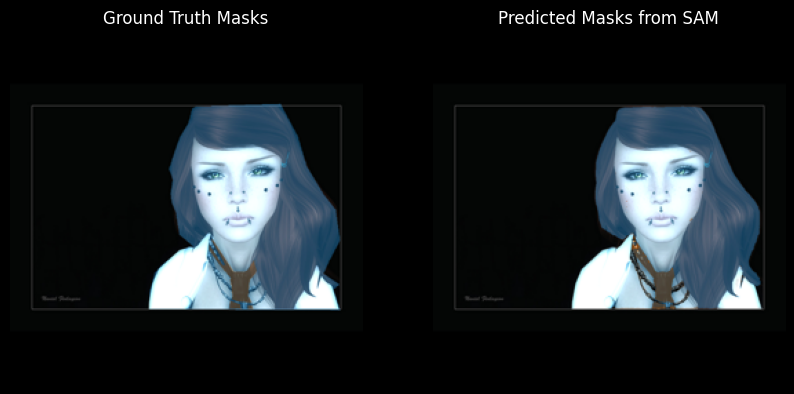

In [10]:
display_ground_truth_and_predicted_segmentation_masks(sample_image, target)

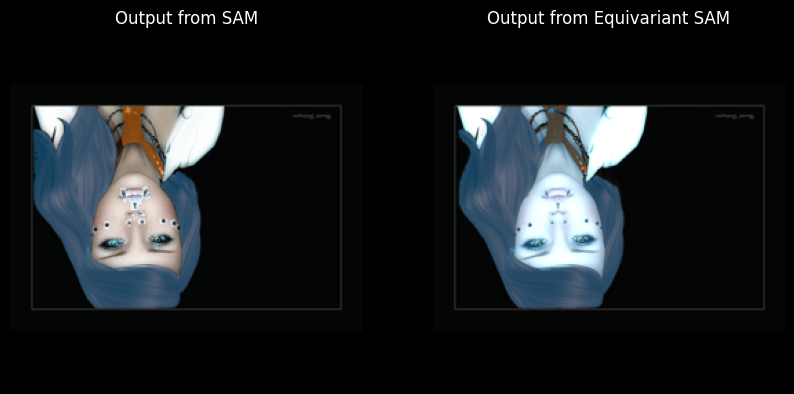

In [11]:
# define the tensor angle to use for rotation
angle = torch.tensor(180.)

get_outputs_with_and_without_canonicalization(sample_image, target, angle)

In [12]:
# get and prepare the image and targets
sample_image, target = sample_images[1], targets[1]
for keys in target.keys(): target[keys] = target[keys].to(device)
target = [target]

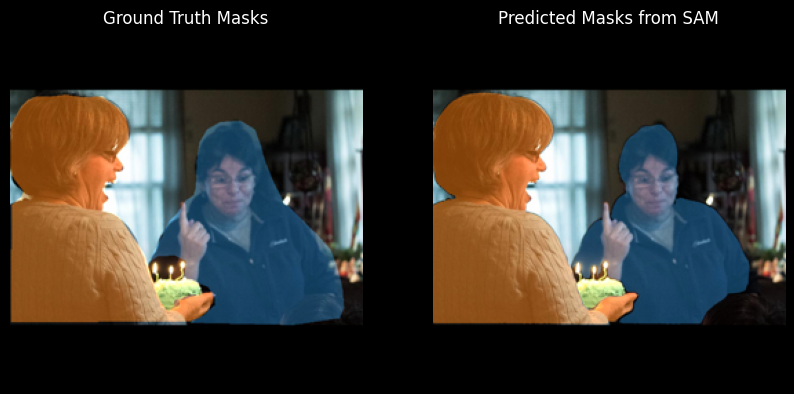

In [13]:
display_ground_truth_and_predicted_segmentation_masks(sample_image, target)

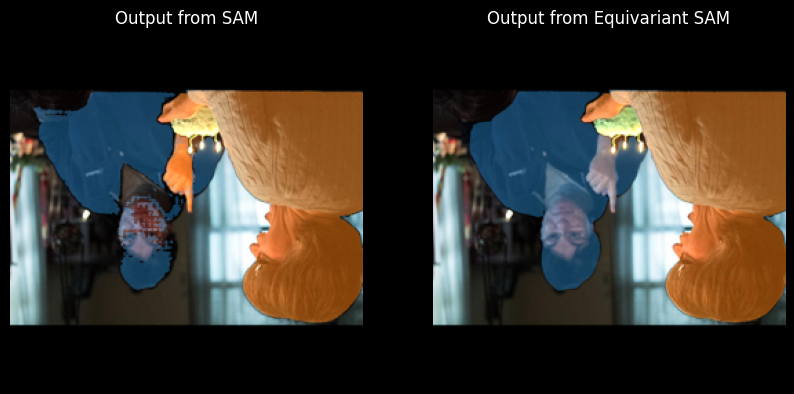

In [14]:
# define the tensor angle to use for rotation
angle = torch.tensor(180.)

get_outputs_with_and_without_canonicalization(sample_image, target, angle)